In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pandas as pd 
import numpy as np 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing

tfk = tf.keras
tfkl = tf.keras.layers

Num GPUs Available:  1


In [2]:
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (64, 23)
EPOCHS = 30
VARIABLES = 23
NFOLD = 5 
STEPS_PER_EPOCH = 200
ID = 28

In [3]:
if ID == 28:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C28.csv'
elif ID == 37:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C37.csv'
else:
    print('Invalid ID')
df_test = pd.read_csv(file, nrows=100)
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(file, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()

In [4]:
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()
sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             589
      1             484
1     0             555
      1             449
2     0             641
      1             552
3     0             343
      1             282
4     0             456
      1             382

In [5]:
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']

In [6]:
preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))
org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)
for i, col in enumerate(input_columns):
    df.loc[:, col] = res[:, i]

D:\Python-Anaconda\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
def get_dataset(df): 

    ids = df.id.unique()

    sensor_datas = []
    afters = [] 

    for id in ids: 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)


    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

In [8]:
def slice_random(x, y):
    start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
    x = x[start: start + BLOCK_SHAPE[0]]
    x = tf.reshape(x, (BLOCK_SHAPE))
    return x, y 

In [9]:
def fix_type(x, y):

    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [10]:
def prepare_for_training(ds, shuffle = False, repeat = False, predict= True):
    
    ds = ds.map(fix_type)
    ds = ds.map(slice_random)

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds

In [11]:
def get_train_and_val_for_fold(folded_datasets, fold):
    predict = True

    train = []
    for i in range(NFOLD-1): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, shuffle=False)
    train_ds = prepare_for_training(train_ds, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, shuffle=False)
    
    return train_ds, val_ds, test_ds

In [12]:
folded_datasets = []

for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))

In [13]:
class Autoencoder(tfk.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(256, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(128, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(32, 3, activation='relu', padding='same', strides=2),
        ])
        
        self.decoder = tf.keras.Sequential([
            tfkl.Conv1DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(1, kernel_size=3, activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
class Conv1D(tfk.Model):
    def __init__(self):
        super(Conv1D, self).__init__()
        self.conv1D_model = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.GlobalAveragePooling1D(),
            tfkl.Dense(1, activation='sigmoid'),
        ])
            
    def call(self, x):
        conv1D = self.conv1D_model(x)
        return conv1D

In [15]:
cnn1D_encoder_result = {}
for i in range(NFOLD-1):
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', 
                                   tfk.metrics.RootMeanSquaredError(),
                                  ],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = autoencoder.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnn1D_encoder_result[i] = result.history

pd.DataFrame(cnn1D_encoder_result)

Epoch 1/30
200/200 [==============================] - 47s 12ms/step - loss: 0.2486 - accuracy: 0.7254 - root_mean_squared_error: 0.4986 - val_loss: 0.2502 - val_accuracy: 0.4672 - val_root_mean_squared_error: 0.5002
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2460 - accuracy: 0.9327 - root_mean_squared_error: 0.4960 - val_loss: 0.2505 - val_accuracy: 0.4631 - val_root_mean_squared_error: 0.5005
Epoch 3/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2418 - accuracy: 0.9582 - root_mean_squared_error: 0.4917 - val_loss: 0.2511 - val_accuracy: 0.4610 - val_root_mean_squared_error: 0.5011
Epoch 4/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2354 - accuracy: 0.9920 - root_mean_squared_error: 0.4852 - val_loss: 0.2522 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5022
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2261 - accuracy: 1.0000 - root_mean_squared_error: 0.4755 - va

Epoch 16/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0453 - accuracy: 1.0000 - root_mean_squared_error: 0.2128 - val_loss: 0.3838 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6195
Epoch 17/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0362 - accuracy: 1.0000 - root_mean_squared_error: 0.1902 - val_loss: 0.4004 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6328
Epoch 18/30
200/200 [==============================] - 4s 20ms/step - loss: 0.0294 - accuracy: 1.0000 - root_mean_squared_error: 0.1716 - val_loss: 0.4157 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6448
Epoch 19/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0245 - accuracy: 1.0000 - root_mean_squared_error: 0.1564 - val_loss: 0.4326 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6577
Epoch 20/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0217 - accuracy: 1.0000 - root_mean_squared_error: 0.1472 

Epoch 24/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0127 - accuracy: 1.0000 - root_mean_squared_error: 0.1125 - val_loss: 0.4938 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7027
Epoch 25/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0113 - accuracy: 1.0000 - root_mean_squared_error: 0.1062 - val_loss: 0.4985 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7061
Epoch 26/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0107 - accuracy: 1.0000 - root_mean_squared_error: 0.1036 - val_loss: 0.5031 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7093
Epoch 27/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0100 - accuracy: 1.0000 - root_mean_squared_error: 0.1001 - val_loss: 0.5038 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7098
Epoch 28/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0095 - accuracy: 1.0000 - root_mean_squared_error: 0.0972 - val

,0,1,2,3
loss,"[0.24864313006401062, 0.24600014090538025, 0.2...","[0.24989569187164307, 0.24840806424617767, 0.2...","[0.2498714029788971, 0.24874310195446014, 0.24...","[0.24877683818340302, 0.24673332273960114, 0.2..."
accuracy,"[0.725390613079071, 0.9326684474945068, 0.9581...","[0.5517602562904358, 0.9097534418106079, 0.999...","[0.5364624261856079, 0.8399707078933716, 0.951...","[0.9651684761047363, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
root_mean_squared_error,"[0.4986412823200226, 0.4959840178489685, 0.491...","[0.4998956620693207, 0.4984055161476135, 0.496...","[0.4998713731765747, 0.49874147772789, 0.49697...","[0.49877533316612244, 0.496722549200058, 0.493..."
val_loss,"[0.25022798776626587, 0.25054121017456055, 0.2...","[0.25007498264312744, 0.25025299191474915, 0.2...","[0.2500453591346741, 0.2501394748687744, 0.250...","[0.2501470744609833, 0.2504032552242279, 0.250..."
val_accuracy,"[0.46718159317970276, 0.46314215660095215, 0.4...","[0.48407572507858276, 0.45293599367141724, 0.4...","[0.48459935188293457, 0.47063714265823364, 0.4...","[0.4638157784938812, 0.4638157784938812, 0.463..."
val_root_mean_squared_error,"[0.5002278685569763, 0.5005409121513367, 0.501...","[0.5000749826431274, 0.5002529621124268, 0.500...","[0.5000453591346741, 0.5001394152641296, 0.500...","[0.5001470446586609, 0.5004030466079712, 0.500..."


In [16]:
cnnv1D_result = {}
for i in range(NFOLD-1):
    conv1D = Conv1D()
    conv1D.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = conv1D.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnnv1D_result[i] = result.history

pd.DataFrame(cnnv1D_result)

Epoch 1/30
200/200 [==============================] - 3s 7ms/step - loss: 0.2531 - accuracy: 0.2136 - root_mean_squared_error: 0.5031 - val_loss: 0.2500 - val_accuracy: 0.4792 - val_root_mean_squared_error: 0.5000
Epoch 2/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2442 - accuracy: 0.9527 - root_mean_squared_error: 0.4941 - val_loss: 0.2509 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5009
Epoch 3/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2349 - accuracy: 0.9983 - root_mean_squared_error: 0.4847 - val_loss: 0.2521 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5021
Epoch 4/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2251 - accuracy: 0.9994 - root_mean_squared_error: 0.4745 - val_loss: 0.2539 - val_accuracy: 0.4574 - val_root_mean_squared_error: 0.5038
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2149 - accuracy: 0.9998 - root_mean_squared_error: 0.4635 - val_loss

Epoch 17/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0546 - accuracy: 1.0000 - root_mean_squared_error: 0.2336 - val_loss: 0.3532 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.5943
Epoch 18/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0480 - accuracy: 1.0000 - root_mean_squared_error: 0.2191 - val_loss: 0.3606 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6005
Epoch 19/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0432 - accuracy: 1.0000 - root_mean_squared_error: 0.2079 - val_loss: 0.3725 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6104
Epoch 20/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0378 - accuracy: 1.0000 - root_mean_squared_error: 0.1943 - val_loss: 0.3811 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6174
Epoch 21/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0342 - accuracy: 1.0000 - root_mean_squared_error: 0.1850 - val

Epoch 25/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0252 - accuracy: 1.0000 - root_mean_squared_error: 0.1588 - val_loss: 0.4242 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6513
Epoch 26/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0226 - accuracy: 1.0000 - root_mean_squared_error: 0.1502 - val_loss: 0.4279 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6541
Epoch 27/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0202 - accuracy: 1.0000 - root_mean_squared_error: 0.1422 - val_loss: 0.4339 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6587
Epoch 28/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0196 - accuracy: 1.0000 - root_mean_squared_error: 0.1399 - val_loss: 0.4420 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6648
Epoch 29/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0175 - accuracy: 1.0000 - root_mean_squared_error: 0.1322 - val

,0,1,2,3
loss,"[0.25313910841941833, 0.24418359994888306, 0.2...","[0.2385454922914505, 0.22860395908355713, 0.21...","[0.25227975845336914, 0.23879671096801758, 0.2...","[0.24657465517520905, 0.23771245777606964, 0.2..."
accuracy,"[0.2135937511920929, 0.9526562690734863, 0.998...","[0.9918749928474426, 0.9995312690734863, 0.999...","[0.3778125047683716, 0.9876562356948853, 1.0, ...","[0.8251562714576721, 0.9976562261581421, 1.0, ..."
root_mean_squared_error,"[0.5031293034553528, 0.4941493570804596, 0.484...","[0.48841118812561035, 0.4781254529953003, 0.46...","[0.5022745728492737, 0.488668292760849, 0.4745...","[0.4965628385543823, 0.48755764961242676, 0.47..."
val_loss,"[0.25004902482032776, 0.2508838176727295, 0.25...","[0.25203633308410645, 0.2532181441783905, 0.25...","[0.2500794231891632, 0.25157156586647034, 0.25...","[0.25073501467704773, 0.2517770826816559, 0.25..."
val_accuracy,"[0.4791666567325592, 0.4583333432674408, 0.458...","[0.4546371102333069, 0.4526209533214569, 0.452...","[0.5, 0.46621620655059814, 0.46621620655059814...","[0.4621710479259491, 0.4638157784938812, 0.463..."
val_root_mean_squared_error,"[0.5000489950180054, 0.5008830428123474, 0.502...","[0.5020321607589722, 0.5032078623771667, 0.505...","[0.5000793933868408, 0.5015690922737122, 0.503...","[0.5007344484329224, 0.5017738938331604, 0.503..."


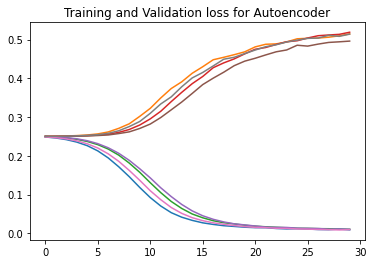

In [17]:
for i in range(NFOLD-1):
    loss = cnn1D_encoder_result[i]['loss']
    val_loss = cnn1D_encoder_result[i]['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Training and Validation loss for Autoencoder')

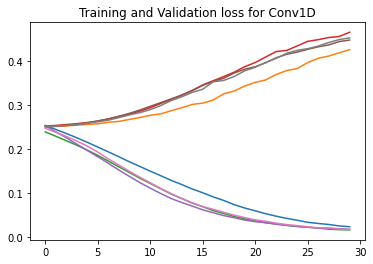

In [18]:
for i in range(NFOLD-1):
    loss = cnnv1D_result[i]['loss']
    val_loss = cnnv1D_result[i]['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Training and Validation loss for Conv1D')

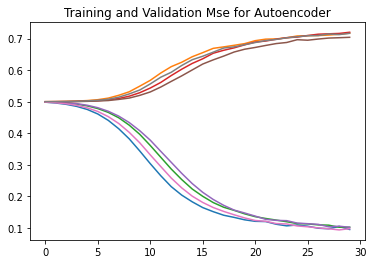

In [19]:
for i in range(NFOLD-1):
    mse = cnn1D_encoder_result[i]['root_mean_squared_error']
    val_mse = cnn1D_encoder_result[i]['val_root_mean_squared_error']
    plt.plot(mse)
    plt.plot(val_mse)
    plt.title('Training and Validation Mse for Autoencoder')

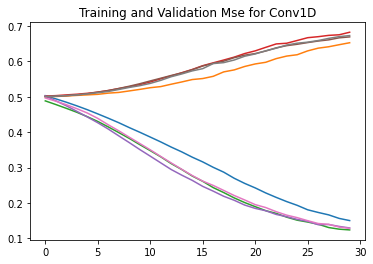

In [20]:
for i in range(NFOLD-1):
    mse = cnnv1D_result[i]['root_mean_squared_error']
    val_mse = cnnv1D_result[i]['val_root_mean_squared_error']
    plt.plot(mse)
    plt.plot(val_mse)
    plt.title('Training and Validation Mse for Conv1D')

26/26 [==============================] - 1s 3ms/step


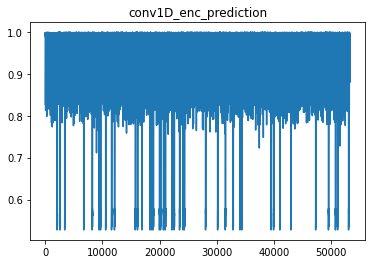

In [21]:
cnn1D_enc_predict = autoencoder.predict(test_dataset, verbose = True)
cnn1D_enc_predict = cnn1D_enc_predict.reshape(-1)
plt.title("conv1D_enc_prediction")
plt.plot(cnn1D_enc_predict)

26/26 [==============================] - 0s 2ms/step


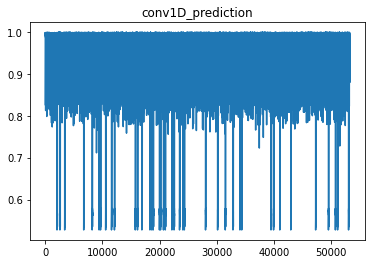

In [22]:
conv1D_predict = conv1D.predict(test_dataset, verbose = True)
plt.title("conv1D_prediction")
plt.plot(cnn1D_enc_predict)